# Problem 2: Spatial Models - Networks
## Implement SIR and Simulate

Watts Strogatz: https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html#networkx.generators.random_graphs.watts_strogatz_graph

Barabasi Albert: https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html#networkx.generators.random_graphs.barabasi_albert_graph

Erdos Reyni: https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html#networkx.generators.random_graphs.erdos_renyi_graph

In [70]:
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
import matplotlib.pyplot as plt
import numpy as np


# Parameter dict
params = {
    'fraction_infected': 0.05,
    'beta': 5,
    'gamma': 1
}

class Vaccination_strategy():
    def __init__(self,strat: str, value: int):
        if strat not in ['random','1stfriend','2ndfriend','tested_2ndfriend']:
            raise ValueError("Vaccination strategy")
        
        self.strat = strat
        self.value = value # vaccinations per timestep available

def test_node(selected_node, model, test_accuracy):
    random_accuracy = np.random.rand()
    status = model.status[selected_node]
    if random_accuracy < test_accuracy:
        return status
    else:
        if status == 0:
            status = 1
        elif status == 1:
            status = 0
        elif status == 2:
            status = 2
    return status

def vaccinate_person(selected_node,model):
    if model.status[selected_node] == 0:
        # Vaccination valid
        model.status[selected_node] = 2
    else:
        # Vaccination invalid, ignore
        pass


# Default/test function for simulation
def simulate_network_sir(graph, max_time, params,seed=0, title=None, plot=False, visualise_network=False, return_trends=False, vaccination=None, test_accuracy = 1,debug=False):
    
    # Taken from ndlib tutorial: https://ndlib.readthedocs.io/en/latest/tutorial.html
    # Model selection
    model = ep.SIRModel(graph)

    # Model Configuration
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', params['beta'])
    cfg.add_model_parameter('gamma', params['gamma'])
    cfg.add_model_parameter('fraction_infected', params['fraction_infected'])
    model.set_initial_status(cfg)

    # Simulation execution
    iterations = []
    for t in range(max_time):
        if seed != 0:
            np.random.seed(seed)
        if debug:
            print(model.status)
        # Progress sickness
        
        iterations.append(model.iteration())
        # If vaccination: perform vaccination
        if vaccination is not None:
            strat = vaccination.strat
            value = vaccination.value
            len_graph = len(graph)
            tries = 0
            if strat == 'random':
                # select <value> random nodes and move them to compartment R
                for i in range(value):
                    vaccinated = False
                    while vaccinated == False and tries < 10:
                        # Move node to compartment R
                        selected_node = np.random.randint(0,len_graph)

                        # Simulate test accuracy
                        status = test_node(selected_node, model, test_accuracy)

                        # If susceptible, vaccinate
                        if status == 0:
                            vaccinate_person(selected_node,model)
                            vaccinated = True
                        tries += 1
                   
            elif strat == '1stfriend':
                # select <value> random nodes, and move one randomly selected 
                # connected node to compartment R
                for i in range(value):
                    vaccinated = False
                    tries = 0
                    while vaccinated == False and tries < 10:
                        selected_node = np.random.randint(0,len_graph)
                        # Find node connections
                        neighbours = list(graph.neighbors(selected_node))
                        while vaccinated == False and tries<10:
                            # Select a random neighbour
                            selected_neighbour = np.random.choice(neighbours)
                            # Simulate test accuracy
                            status = test_node(selected_neighbour, model, test_accuracy)
                            # Move node to compartment R
                            if status == 0:
                                vaccinate_person(selected_neighbour,model)
                                vaccinated = True
                            
                            tries += 1

                    

            elif strat == '2ndfriend':
                # select <value> random nodes, and move one randomly selected 
                # connected node to compartment R
                for i in range(value):
                    vaccinated = False                    
                    tries = 0
                    while vaccinated == False and tries<10:
                        # Select random node
                        selected_node = np.random.randint(0,len_graph)
                        # Find node connections
                        neighbours = list(graph.neighbors(selected_node))
                        # Select a random neighbour
                        neighbour = np.random.choice(neighbours)
                        
                        while vaccinated == False and tries<10:
                            # Find node connections
                            neighbours2 = list(graph.neighbors(neighbour))

                            selected_neighbour = np.random.choice(neighbours2)
                            
                            # Simulate test accuracy
                            status = test_node(selected_neighbour, model, test_accuracy)
                            # Move node to compartment R
                            if status == 0:
                                vaccinate_person(selected_neighbour,model)
                                vaccinated = True
                            
                            tries += 1

                    

    # Collecting the trends
    trends = model.build_trends(iterations)

    # Plotting the trends
    if plot:
        viz = DiffusionTrend(model, trends)
        print(trends)
        viz.ylabel = "Fraction of nodes"
        viz.normalized = False
        viz.title = title
        viz.plot()

    # Visualising the network
    if visualise_network:
        pos = nx.spring_layout(graph)  # or any layout you prefer
        nx.draw_networkx_nodes(graph, pos, node_size=10, node_color="blue", alpha=1.0)
        nx.draw_networkx_edges(graph, pos, edge_color="black", alpha=0.3)
        plt.show()
    
    if return_trends:   
        return trends




[{'trends': {'node_count': {0: [190, 175, 146, 112, 73, 49, 39, 28, 26, 26], 1: [10, 15, 29, 34, 39, 24, 10, 11, 2, 0], 2: [0, 10, 25, 54, 88, 127, 151, 161, 172, 174]}, 'status_delta': {0: [0, -15, -29, -34, -39, -24, -10, -11, -2, 0], 1: [0, 5, 14, 5, 5, -15, -14, 1, -9, -2], 2: [0, 10, 15, 29, 34, 39, 24, 10, 11, 2]}}}]


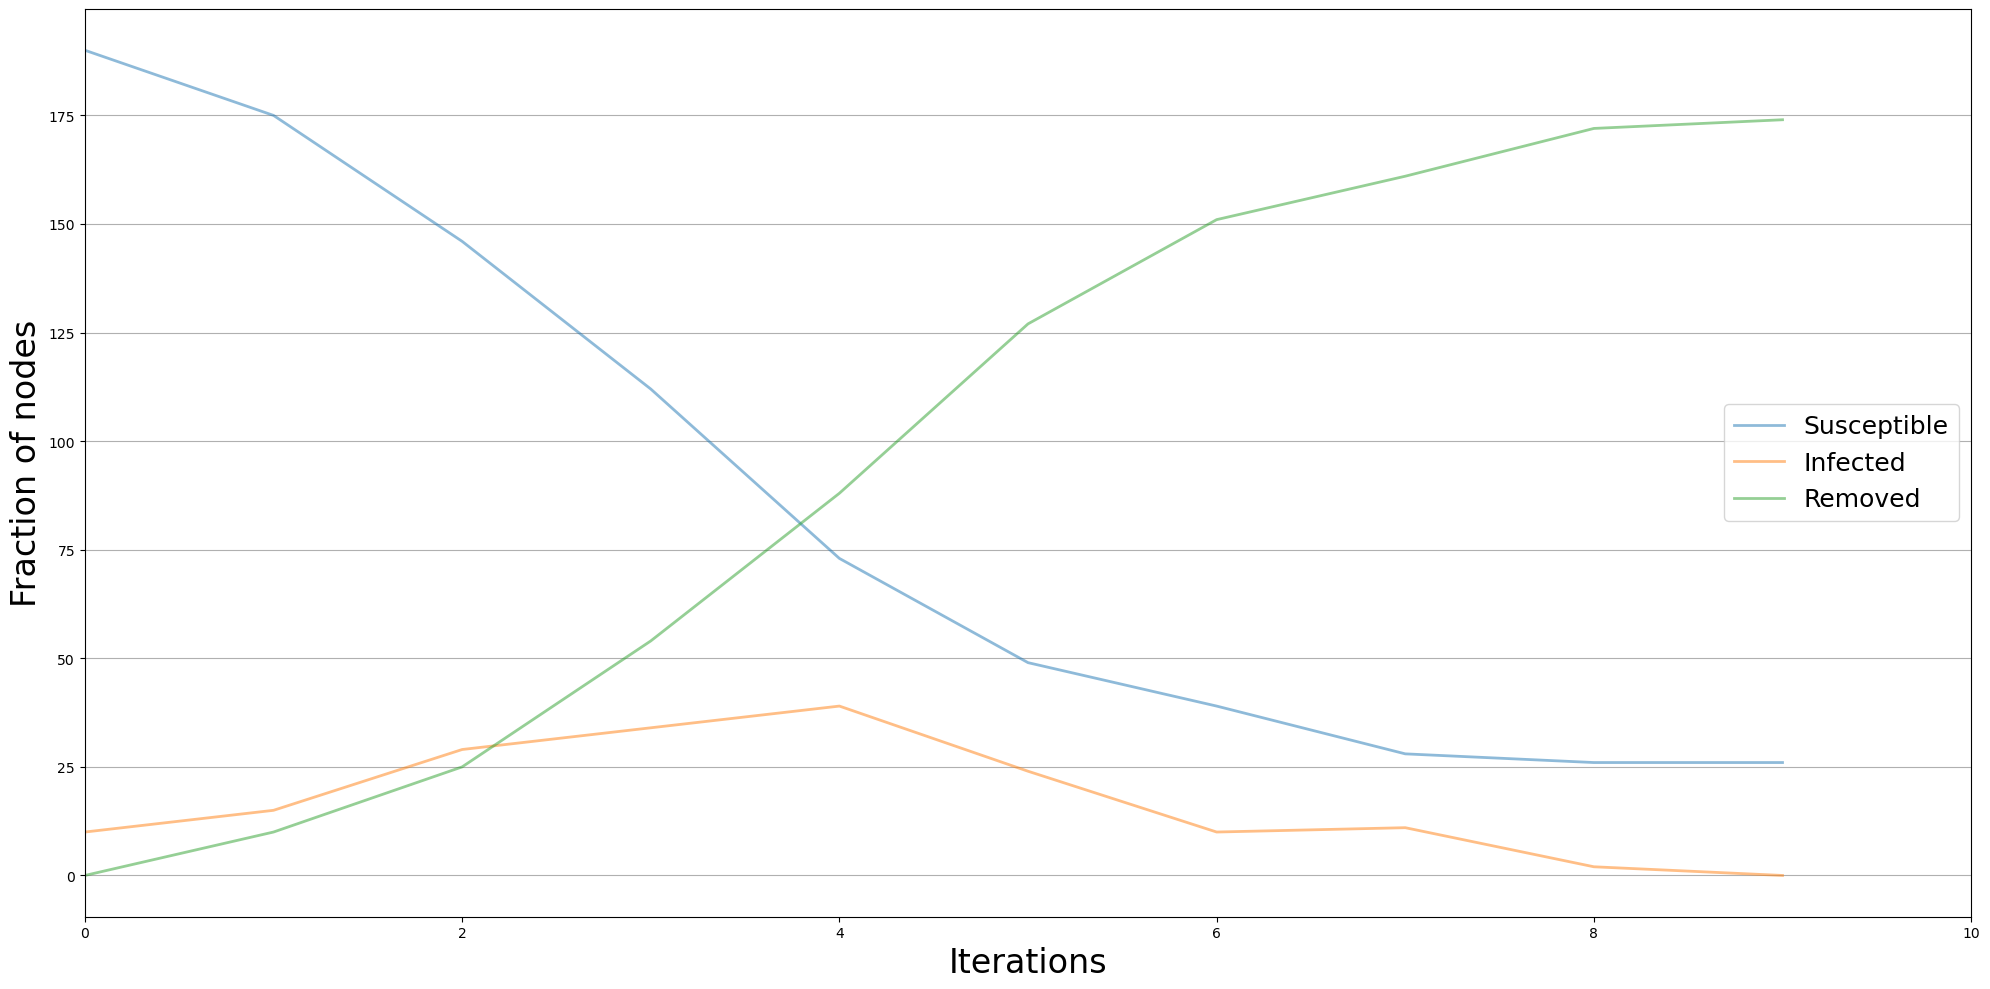

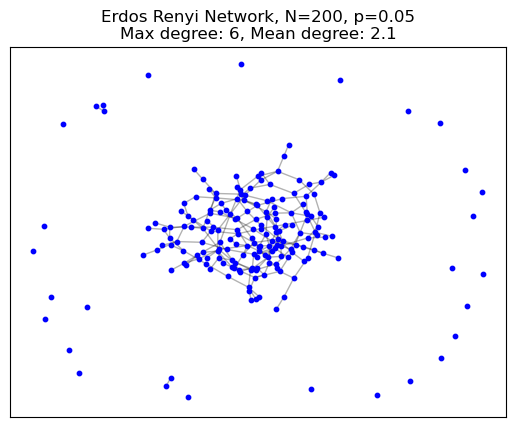

[{'trends': {'node_count': {0: [190, 154, 73, 20, 4, 1, 0, 0, 0, 0], 1: [10, 36, 81, 53, 16, 3, 1, 0, 0, 0], 2: [0, 10, 46, 127, 180, 196, 199, 200, 200, 200]}, 'status_delta': {0: [0, -36, -81, -53, -16, -3, -1, 0, 0, 0], 1: [0, 26, 45, -28, -37, -13, -2, -1, 0, 0], 2: [0, 10, 36, 81, 53, 16, 3, 1, 0, 0]}}}]


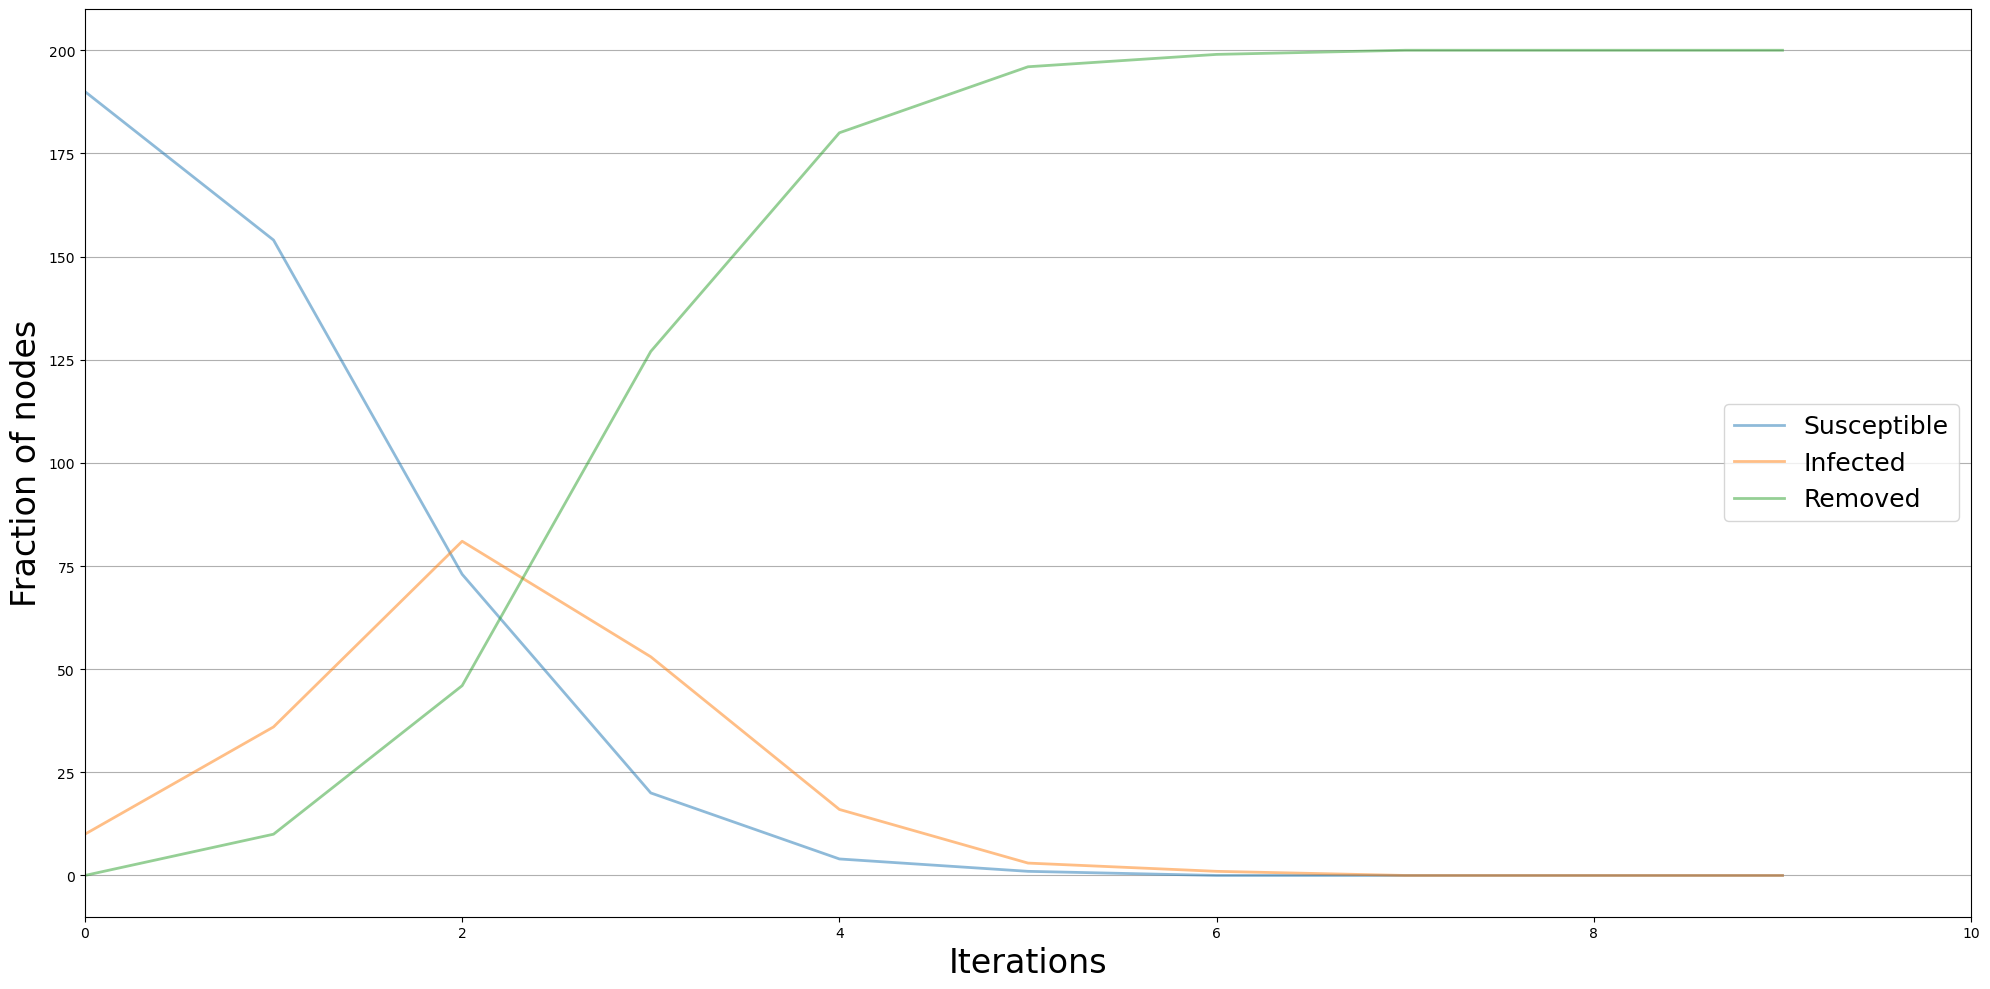

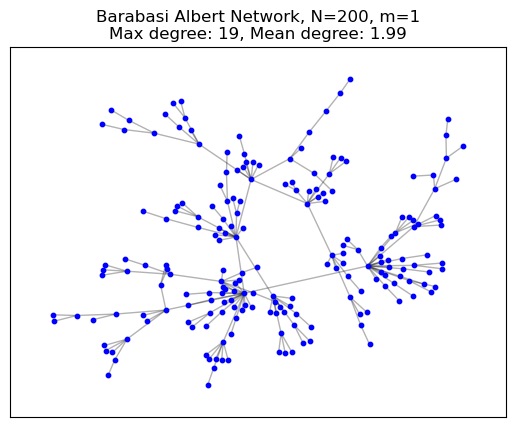

[{'trends': {'node_count': {0: [190, 155, 117, 70, 30, 11, 2, 0, 0, 0], 1: [10, 35, 38, 47, 40, 19, 9, 2, 0, 0], 2: [0, 10, 45, 83, 130, 170, 189, 198, 200, 200]}, 'status_delta': {0: [0, -35, -38, -47, -40, -19, -9, -2, 0, 0], 1: [0, 25, 3, 9, -7, -21, -10, -7, -2, 0], 2: [0, 10, 35, 38, 47, 40, 19, 9, 2, 0]}}}]


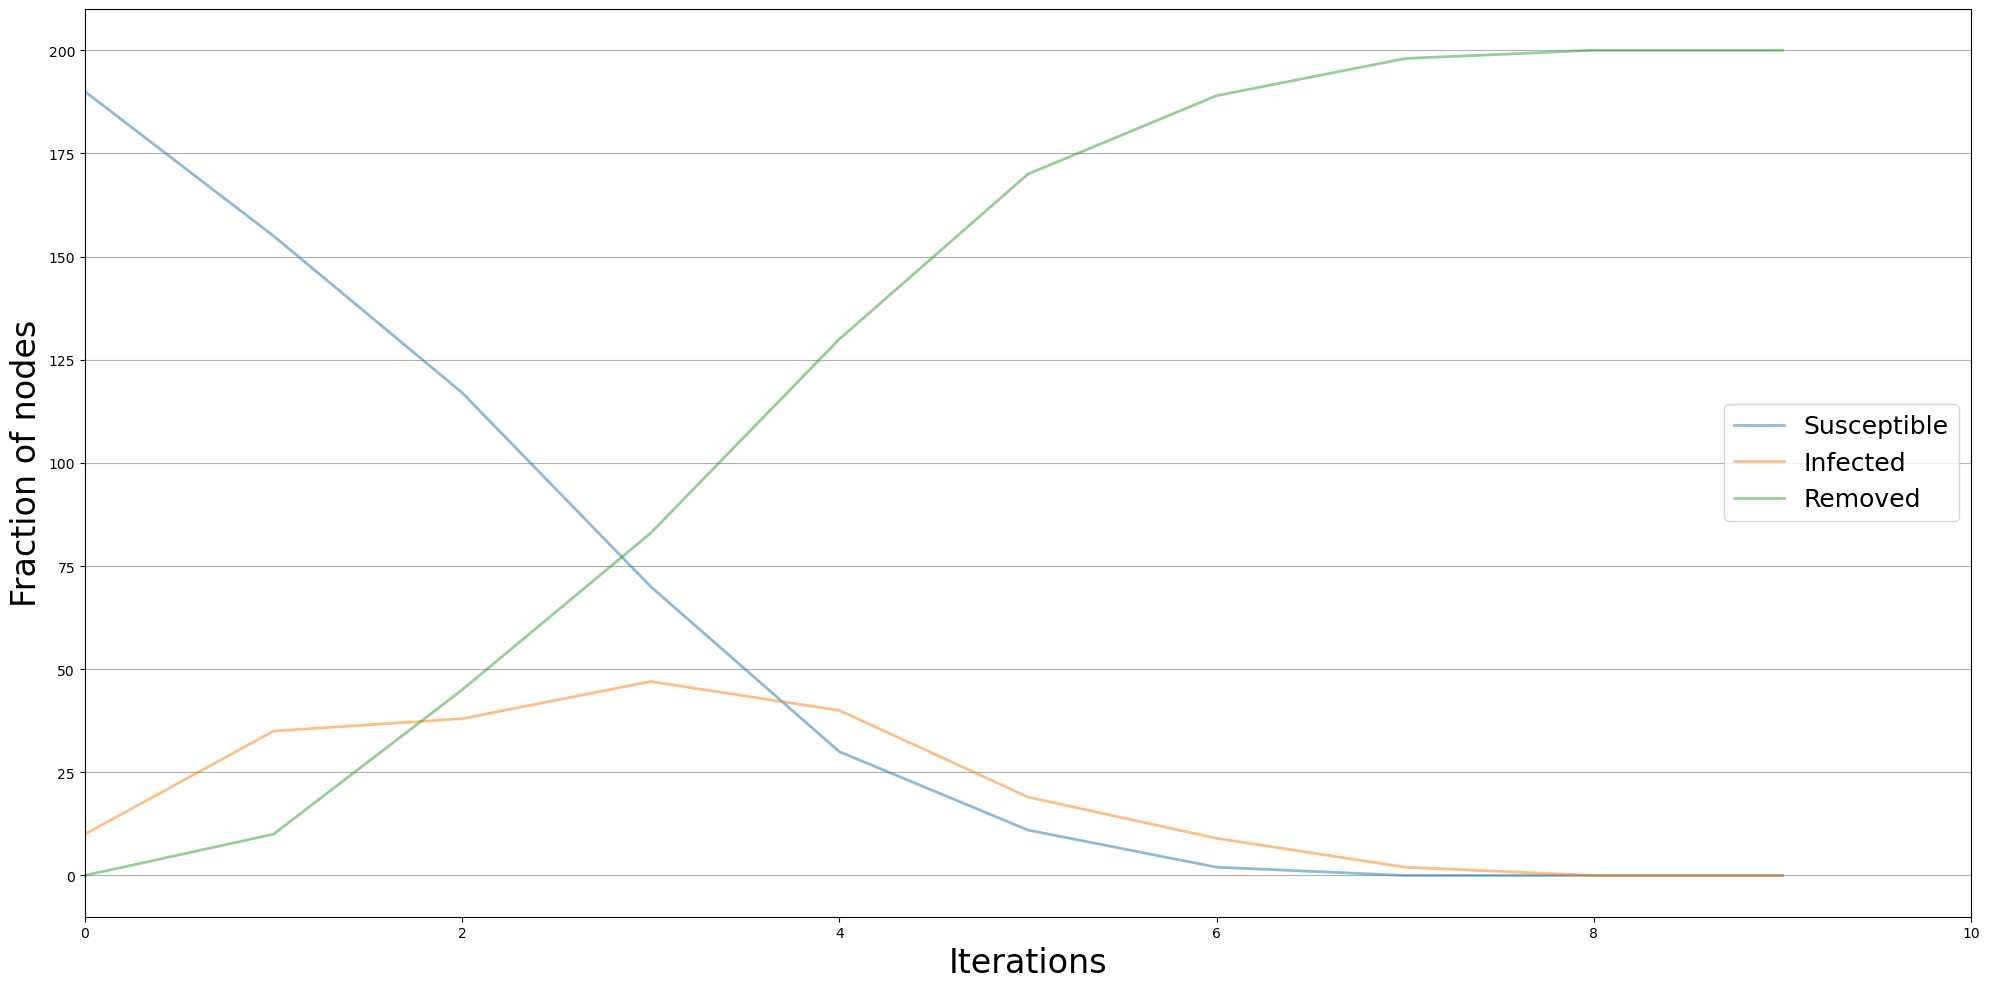

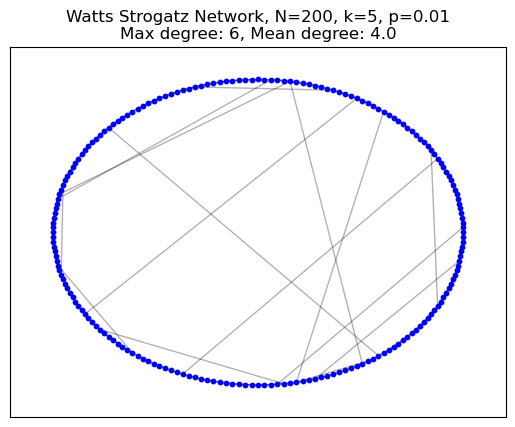

In [103]:
# Plot network topology for intuitive/qualitative understanding
# Erdos Renyi, Barabasi Albert, Watts Strogatz
%matplotlib inline
params = {
    'fraction_infected': 0.05,
    'beta': 5,
    'gamma': 1
}

# Erdos Renyi
g = nx.erdos_renyi_graph(200, 0.01) # N nodes, p chance for edge creation
simulate_network_sir(g,10,params,plot=True,title="Erdos Renyi")

pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, node_size=10, node_color="blue", alpha=1.0)
nx.draw_networkx_edges(g, pos, edge_color="black", alpha=0.3)
degrees = [d for n, d in g.degree()]
max_degree = max(degrees)
mean_degree = sum(degrees) / len(degrees)

plt.title("Erdos Renyi Network, N=200, p=0.05" + "\n" + "Max degree: " + str(round(max_degree,3)) + ", Mean degree: " + str(round(mean_degree,2)))
plt.show()

# Barabasi Albert
g = nx.barabasi_albert_graph(200,1) # N nodes, m edges from new node
simulate_network_sir(g,10,params,plot=True,title="Barabasi Albert")

pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, node_size=10, node_color="blue", alpha=1.0)
nx.draw_networkx_edges(g, pos, edge_color="black", alpha=0.3)
degrees = [d for n, d in g.degree()]
max_degree = max(degrees)
mean_degree = sum(degrees) / len(degrees)

plt.title("Barabasi Albert Network, N=200, m=1" + "\n" + "Max degree: " + str(round(max_degree,3)) + ", Mean degree: " + str(round(mean_degree,2)))
plt.show()

# Watts Strogatz
g = nx.watts_strogatz_graph(200,5,0.05) # N nodes, k connected neighbours, p probability of rewiring each edge
simulate_network_sir(g,10,params,plot=True,title="Watts Strogatz")

pos = nx.shell_layout(g)
nx.draw_networkx_nodes(g, pos, node_size=10, node_color="blue", alpha=1.0)
nx.draw_networkx_edges(g, pos, edge_color="black", alpha=0.3)
degrees = [d for n, d in g.degree()]
max_degree = max(degrees)
mean_degree = sum(degrees) / len(degrees)
plt.title("Watts Strogatz Network, N=200, k=5, p=0.01" + "\n" + "Max degree: " + str(round(max_degree,3)) + ", Mean degree: " + str(round(mean_degree,2)))
plt.show()



In [114]:
import csv
import numpy as np
class graph_experiment:
    def __init__(self, type, nodes, parameter, times_run):
        self.times_run = times_run
        
        self.nodes = nodes
        self.type = type
        self.parameter = parameter
        
        self.mean_degree = np.zeros((times_run,len(nodes), len(parameter)))
        self.clustering = np.zeros((times_run,len(nodes), len(parameter)))
        self.diameter = np.zeros((times_run,len(nodes), len(parameter)))
        self.mean_inbetweenness = np.zeros((times_run,len(nodes), len(parameter)))
        self.mean_closeness = np.zeros((times_run,len(nodes), len(parameter)))

        self.mean_degree_std= np.zeros((len(nodes),len(parameter)))
        self.clustering_std= np.zeros((len(nodes), len(parameter)))
        self.diameter_std= np.zeros((len(nodes), len(parameter)))
        self.mean_inbetweenness_std= np.zeros((len(nodes), len(parameter)))
        self.mean_closeness_std= np.zeros((len(nodes), len(parameter)))

        self.avg_mean_degree = np.zeros((len(nodes), len(parameter)))
        self.avg_clustering = np.zeros((len(nodes), len(parameter)))
        self.avg_diameter = np.zeros((len(nodes), len(parameter)))
        self.avg_mean_inbetweenness = np.zeros((len(nodes), len(parameter)))
        self.avg_mean_closeness = np.zeros((len(nodes), len(parameter)))

    def calculate_stats(self):
        self.avg_mean_degree = np.mean(self.mean_degree,0)
        self.avg_clustering = np.mean(self.clustering,0)
        self.avg_diameter = np.mean(self.diameter,0)
        self.avg_mean_inbetweenness = np.mean(self.mean_inbetweenness,0)
        self.avg_mean_closeness = np.mean(self.mean_closeness,0)

        self.mean_degree_std= np.std(self.mean_degree,0)
        self.clustering_std= np.std(self.clustering,0)
        self.diameter_std= np.std(self.diameter,0)
        self.mean_inbetweenness_std= np.std(self.mean_inbetweenness,0)
        self.mean_closeness_std= np.std(self.mean_closeness,0)


    def save_to_csv(self, filename_prefix):
        header = np.zeros((1, len(self.parameter))) + self.times_run
        # Save results to CSV files
        separator = np.zeros(len(self.parameter))-1
        combined = np.vstack((header,
                              self.avg_mean_degree, 
                              separator, self.avg_clustering, 
                              separator, self.avg_diameter, 
                              separator, self.avg_mean_inbetweenness, 
                              separator, self.avg_mean_closeness,
                              separator, self.mean_degree_std, 
                              separator, self.clustering_std, 
                              separator, self.diameter_std, 
                              separator, self.mean_inbetweenness_std, 
                              separator, self.mean_closeness_std))
        # Save to CSV
        np.savetxt(f'{filename_prefix}.csv', combined, delimiter=';', fmt='%s')

    def read_from_csv(self, filename_prefix):
        data = np.loadtxt(f'{filename_prefix}.csv', delimiter=';')
        # Assuming the structure is known and fixed
        self.times_run = data[0,0]
        
        self.avg_mean_degree =   data[1:1+len(self.nodes)]
        self.avg_clustering =       data[2+len(self.nodes):2+2*len(self.nodes)]
        self.avg_diameter =         data[3+2*len(self.nodes):3+3*len(self.nodes)]
        self.avg_mean_inbetweenness=data[4+3*len(self.nodes):4+4*len(self.nodes)]
        self.avg_mean_closeness =   data[5+4*len(self.nodes):5+5*len(self.nodes)]

        self.mean_degree_std =   data[6+5*len(self.nodes):6+6*len(self.nodes)]
        self.clustering_std_std =   data[7+6*len(self.nodes):7+7*len(self.nodes)]
        self.diameter_std =         data[8+7*len(self.nodes):8+8*len(self.nodes)]
        self.mean_inbetweenness_std =    data[9+8*len(self.nodes):9+9*len(self.nodes)]
        self.mean_closeness_std =        data[10+9*len(self.nodes):10+10*len(self.nodes)]

    def combine_results(self, other):
        
        self.avg_mean_degree =   (other.avg_mean_degree*other.times_run + self.avg_mean_degree*self.times_run) / (self.times_run + other.times_run)
        self.avg_clustering =       (other.avg_clustering*other.times_run + self.avg_clustering*self.times_run) / (self.times_run + other.times_run)
        self.avg_diameter =         (other.avg_diameter*other.times_run + self.avg_diameter*self.times_run) / (self.times_run + other.times_run)
        self.avg_mean_inbetweenness=(other.avg_mean_inbetweenness*other.times_run + self.avg_mean_inbetweenness*self.times_run) / (self.times_run + other.times_run)
        self.avg_mean_closeness =   (other.avg_mean_closeness*other.times_run + self.avg_mean_closeness*self.times_run) / (self.times_run + other.times_run)
        
        self.mean_degree_std =       np.sqrt((np.square(self.mean_degree_std)*(self.times_run-1) + np.square(other.mean_degree_std)*(other.times_run-1))/(self.times_run+other.times_run-2))
        self.clustering_std =           np.sqrt((np.square(self.clustering_std)*(self.times_run-1) + np.square(other.clustering_std)*(other.times_run-1))/(self.times_run+other.times_run-2))
        self.diameter_std =             np.sqrt((np.square(self.diameter_std)*(self.times_run-1) + np.square(other.diameter_std)*(other.times_run-1))/(self.times_run+other.times_run-2))
        self.mean_inbetweenness_std =   np.sqrt((np.square(self.mean_inbetweenness_std)*(self.times_run-1) + np.square(other.mean_inbetweenness_std)*(other.times_run-1))/(self.times_run+other.times_run-2))
        self.mean_closeness_std =       np.sqrt((np.square(self.mean_closeness_std)*(self.times_run-1) + np.square(other.mean_closeness_std)*(other.times_run-1))/(self.times_run+other.times_run-2))

        self.times_run += other.times_run
        print("Done")
        
def plot_heatmaps(mean_degree, clustering, ns, ps,type):
    # Plot heatmaps
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"{type} Network Properties")
    plt.subplot(1, 2, 1)
    sns.heatmap(mean_degree, xticklabels=np.round(ps, 2), yticklabels=np.round(ns, 0), cmap="YlGnBu")
    plt.title("Median Degree")
    if type == 'barabasi_albert':
        plt.xlabel("Number of edges m")
        plt.ylabel("Number of Nodes n")
    elif type == 'watts_strogatz':
        plt.xlabel("Probability p")
        plt.ylabel("Number of connected neighbours k")
    elif type == 'erdos_renyi':
        plt.xlabel("Probability p")
        plt.ylabel("Number of Nodes n")

    plt.subplot(1, 2, 2)
    sns.heatmap(clustering, xticklabels=np.round(ps, 2), yticklabels=np.round(ns, 0), cmap="YlGnBu")
    plt.title("Clustering Coefficient")
    if type == 'barabasi_albert':
        plt.xlabel("Number of edges m")
        plt.ylabel("Number of Nodes n")
    elif type == 'watts_strogatz':
        plt.xlabel("Probability p")
        plt.ylabel("Number of connected neighbours k")
    elif type == 'erdos_renyi':
        plt.xlabel("Probability p")
        plt.ylabel("Number of Nodes n")
    plt.show()


def graph_exploration(type,A, B, N):

    result = graph_experiment(type, A, B, N)

    for n in range(N):
        print("computing {}, {}".format(type,n))
        for i, a in enumerate(A):
            print("N={}".format(a))
            for j, b in enumerate(B):
                if type == 'erdos_renyi':
                    g = nx.erdos_renyi_graph(int(a),b)
                elif type == 'barabasi_albert':
                    g = nx.barabasi_albert_graph(int(a), int(b))
                elif type == 'watts_strogatz':
                    g = nx.watts_strogatz_graph(int(a), 5, b)
                else:
                    raise ValueError("Unknown graph type")
                
                degrees = [d for n, d in g.degree()]
                result.mean_degree[n, i, j] = np.sum(degrees) / len(degrees)
                result.clustering[n, i, j] = nx.average_clustering(g)
                result.mean_inbetweenness[n, i, j] = np.mean(list(nx.betweenness_centrality(g).values()))
                result.mean_closeness[n, i, j] = np.mean(list(nx.closeness_centrality(g).values()))

                if type != 'erdos_renyi':
                    result.diameter[n, i, j] += nx.diameter(g)
                else:
                    Gcc = sorted(nx.connected_components(g), key=len, reverse=True)
                    G0 = g.subgraph(Gcc[0])
                    result.diameter[n,i, j] += nx.diameter(G0)
    result.calculate_stats()
    return result

def plot_graph_exploration(result):
    plt.figure(figsize=(15, 10))
    plt.subplot(2,3,1)
    if result.type == 'barabasi_albert':
        param_name='m'
    else:
        param_name='p'

    for i, a in enumerate(result.parameter):
        plt.plot(result.nodes,result.avg_mean_degree[:,i], label=f"{param_name}={a}")
        plt.fill_between(result.nodes, result.avg_mean_degree[:,i]-result.mean_degree_std[:,i], result.avg_mean_degree[:,i]+result.mean_degree_std[:,i], color='b', alpha=0.2)
    plt.xlabel("Number of Nodes n")
    plt.ylabel("Mean Degree")
    plt.title("Mean Degree")
    plt.legend(loc='center right')

    plt.subplot(2,3,2)
    for i, a in enumerate(result.parameter):
        plt.plot(result.nodes,result.avg_clustering[:,i], label=f"{param_name}={a}")
        plt.fill_between(result.nodes, result.avg_clustering[:,i]-result.clustering_std[:,i], result.avg_clustering[:,i]+result.clustering_std[:,i], color='b', alpha=0.2)

    plt.xlabel("Number of Nodes n")
    plt.ylabel("Average Clustering")
    plt.title("Average clustering")
    plt.legend(loc='center right')

    plt.subplot(2,3,3)
    for i, a in enumerate(result.parameter):
        plt.plot(result.nodes,result.avg_diameter[:,i], label=f"{param_name}={a}")
        plt.fill_between(result.nodes, result.avg_diameter[:,i]-result.diameter_std[:,i], result.avg_diameter[:,i]+result.diameter_std[:,i], color='b', alpha=0.2)

    plt.xlabel("Number of Nodes n")
    plt.ylabel("Network Diameter")
    plt.title("Diameter of the giant compartment")
    plt.legend(loc='center right')

    plt.subplot(2,3,4)
    for i, a in enumerate(result.parameter):
        plt.plot(result.nodes,result.avg_mean_inbetweenness[:,i], label=f"{param_name}={a}")
        plt.fill_between(result.nodes, result.avg_mean_inbetweenness[:,i]-result.mean_inbetweenness_std[:,i], result.avg_mean_inbetweenness[:,i]+result.mean_inbetweenness_std[:,i], color='b', alpha=0.2)

    plt.xlabel("Number of Nodes n")
    plt.ylabel("Mean In-Betweenness")
    plt.title("Mean In-Betweenness")
    plt.legend(loc='center right')

    plt.subplot(2,3,5)
    for i, a in enumerate(result.parameter):
        plt.plot(result.nodes,result.avg_mean_closeness[:,i], label=f"{param_name}={a}")
        plt.fill_between(result.nodes, result.avg_mean_closeness[:,i]-result.mean_closeness_std[:,i], result.avg_mean_closeness[:,i]+result.mean_closeness_std[:,i], color='b', alpha=0.2)

    plt.xlabel("Number of Nodes n")
    plt.ylabel("Mean Closeness")
    plt.title("Mean Closeness")
    plt.legend(loc='center right')

    plt.tight_layout()
    plt.suptitle("{} Network Properties, runs={}".format(result.type,result.times_run), y=1.02)
    plt.show()


In [ ]:

N = 2
# Erdos renyi params
ns_er = np.linspace(100, 500, 5,dtype=int)
ps_er = [0.001,0.01,0.1,0.5]

# Barabasi Albert params
ns_ba = np.linspace(100, 500, 5,dtype=int)
ms_ba = [1,2,4,8]

# Watts Strogatz params
ns_ws = np.linspace(100, 500, 5,dtype=int)
ps_ws = [0.001, 0.01, 0.1, 0.5]

computing barabasi_albert, 0
N=100
N=200
N=300
N=400
N=500
computing barabasi_albert, 1
N=100
N=200
N=300
N=400
N=500
computing barabasi_albert, 2
N=100
N=200
N=300
N=400
N=500
computing barabasi_albert, 3
N=100
N=200
N=300
N=400
N=500
computing barabasi_albert, 4
N=100
N=200
N=300
N=400
N=500
computing barabasi_albert, 5
N=100
N=200
N=300
N=400
N=500
computing barabasi_albert, 6
N=100
N=200
N=300
N=400
N=500
computing barabasi_albert, 7
N=100
N=200
N=300
N=400
N=500
computing barabasi_albert, 8
N=100
N=200
N=300
N=400
N=500
computing barabasi_albert, 9
N=100
N=200
N=300
N=400
N=500


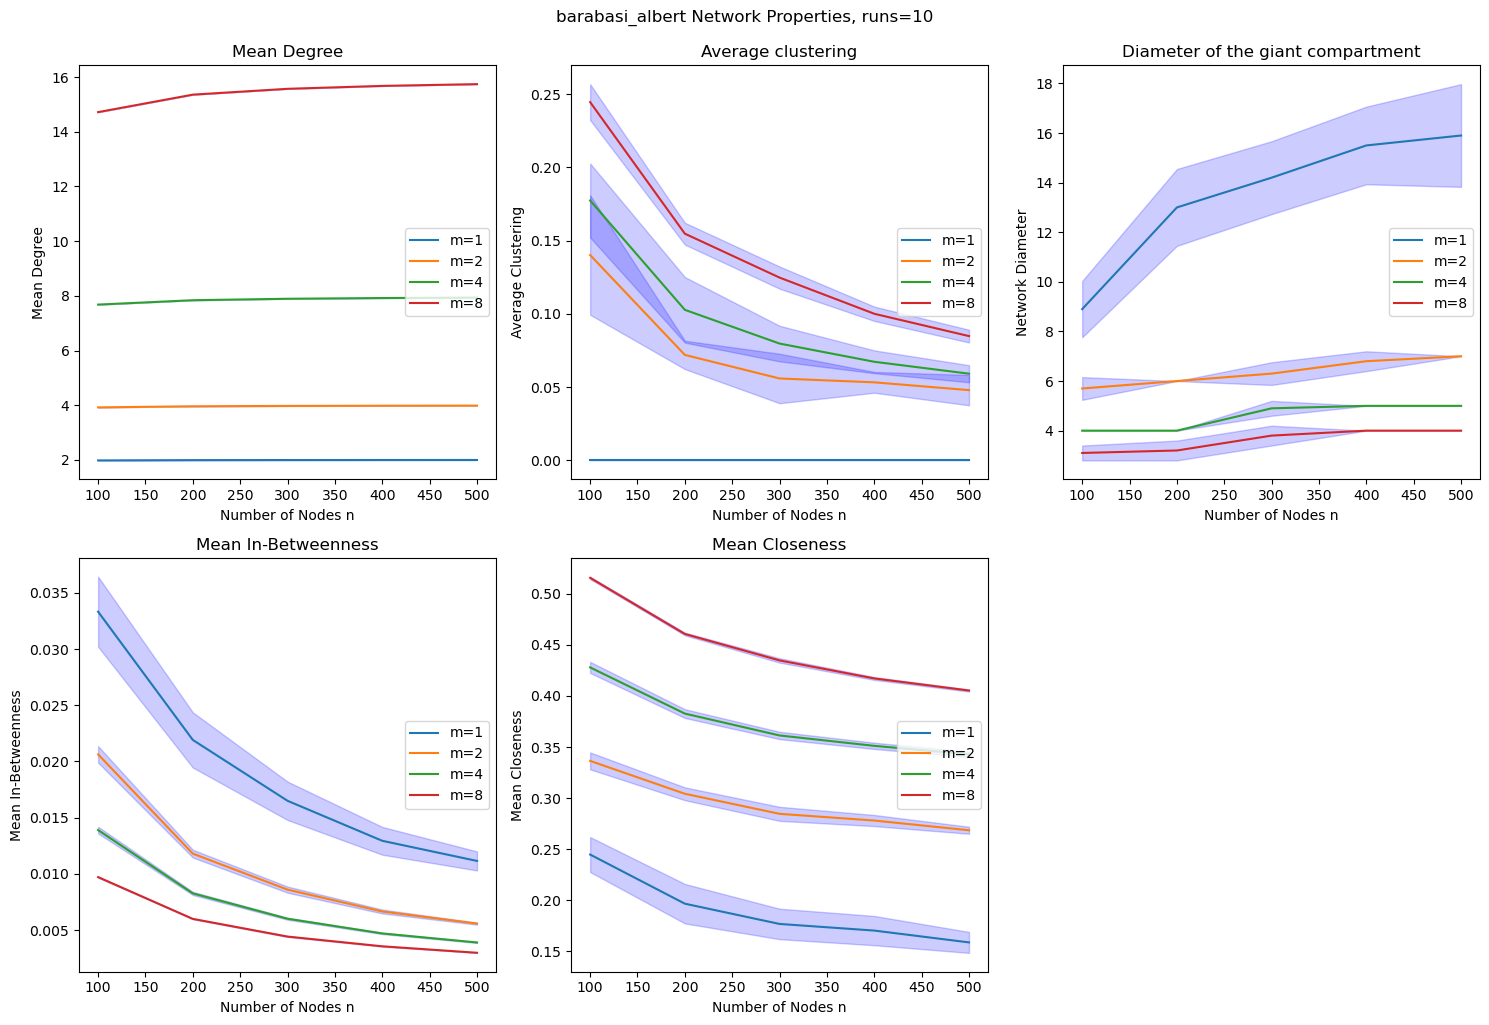

In [115]:
result_ba = graph_exploration('barabasi_albert',ns_ba,ms_ba,10)
result_ba.save_to_csv('barabasi_albert')
# for m in range(0,4):
#     print(f"M={m}")
#     new_results_ba = graph_exploration('barabasi_albert',ns_ba,ms_ba,10)
#     old_results_ba = graph_experiment('barabasi_albert',ns_ba,ms_ba,0)
#     old_results_ba.read_from_csv('barabasi_albert')
#     new_results_ba.combine_results(old_results_ba)
#     new_results_ba.save_to_csv('barabasi_albert')

plot_graph_exploration(result_ba)

computing watts_strogatz, 0
N=100
N=200
N=300
N=400
N=500
computing watts_strogatz, 1
N=100
N=200
N=300
N=400
N=500
computing watts_strogatz, 2
N=100
N=200
N=300
N=400
N=500
computing watts_strogatz, 3
N=100
N=200
N=300
N=400
N=500
computing watts_strogatz, 4
N=100
N=200
N=300
N=400
N=500
computing watts_strogatz, 5
N=100
N=200
N=300
N=400
N=500
computing watts_strogatz, 6
N=100
N=200
N=300
N=400
N=500
computing watts_strogatz, 7
N=100
N=200
N=300
N=400
N=500
computing watts_strogatz, 8
N=100
N=200
N=300
N=400
N=500
computing watts_strogatz, 9
N=100
N=200
N=300
N=400
N=500


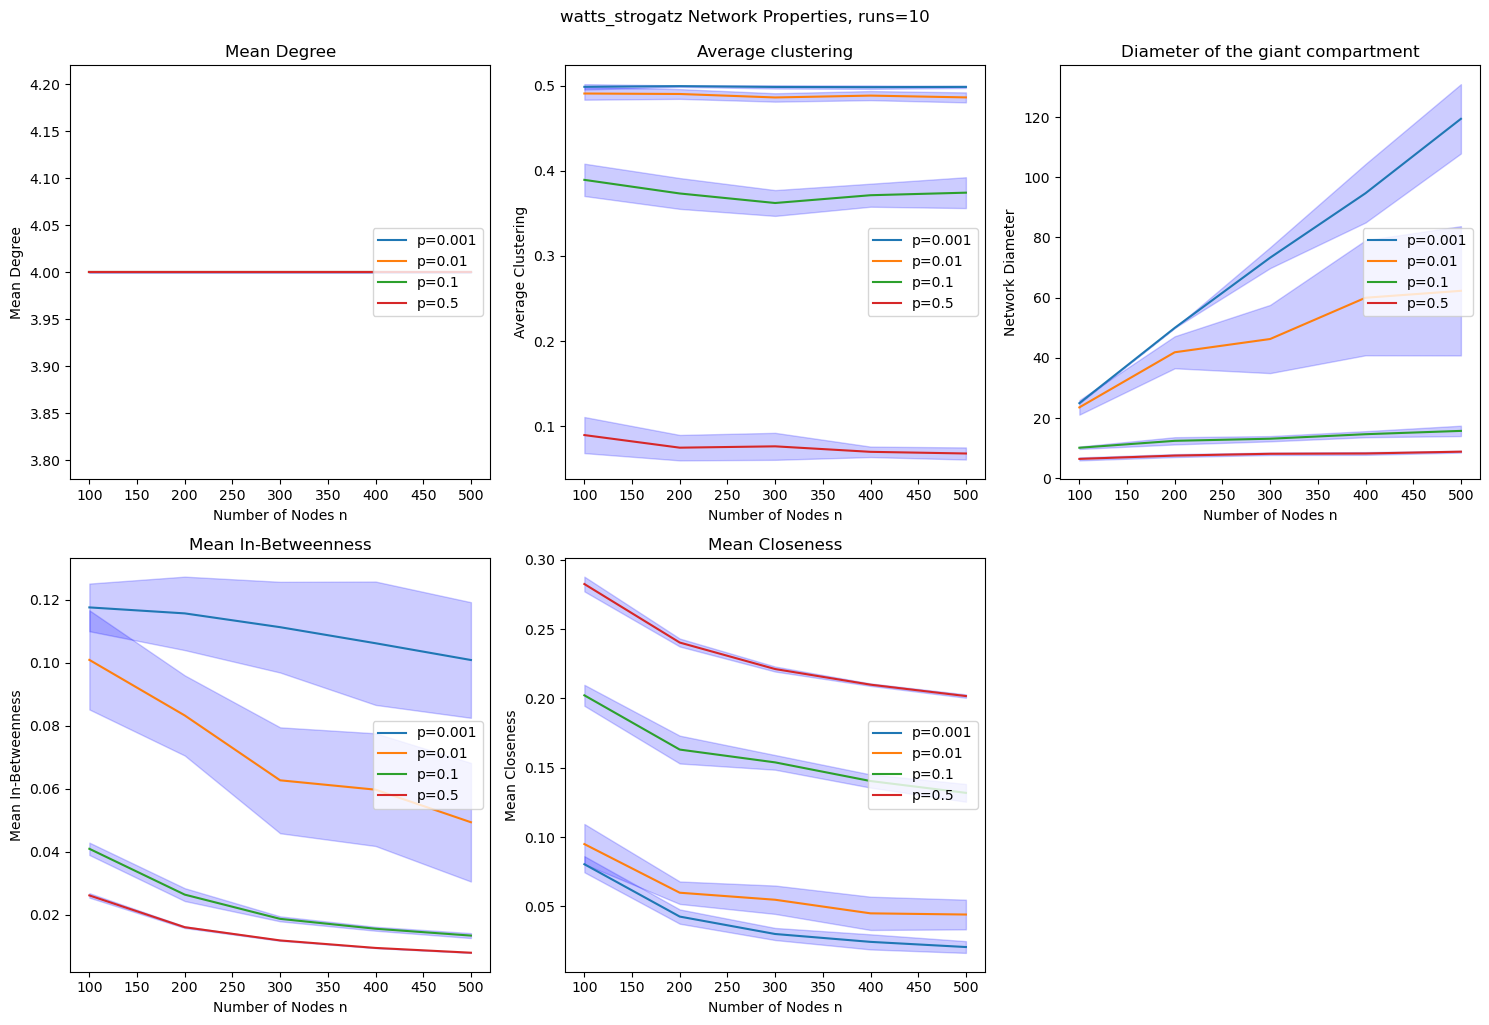

In [120]:
result_ws = graph_exploration('watts_strogatz',ns_ws,ps_ws,10)
result_ws.save_to_csv('watts_strogatz')
# for m in range(0,4):
#     print(f"M={m}")
#     new_results_ws = graph_exploration('watts_strogatz',ns_ws,ps_ws,10)
#     old_results_ws = graph_experiment('watts_strogatz',ns_ws,ps_ws,0)
#     old_results_ws.read_from_csv('watts_strogatz')
#     new_results_ws.combine_results(old_results_ws)
#     new_results_ws.save_to_csv('watts_strogatz')

plot_graph_exploration(result_ws)

computing erdos_renyi, 0
N=100
N=200
N=300
N=400
N=500
computing erdos_renyi, 1
N=100
N=200
N=300
N=400
N=500
computing erdos_renyi, 2
N=100
N=200
N=300
N=400
N=500
computing erdos_renyi, 3
N=100
N=200
N=300
N=400
N=500
computing erdos_renyi, 4
N=100
N=200
N=300
N=400
N=500
computing erdos_renyi, 5
N=100
N=200
N=300
N=400
N=500
computing erdos_renyi, 6
N=100
N=200
N=300
N=400
N=500
computing erdos_renyi, 7
N=100
N=200
N=300
N=400
N=500
computing erdos_renyi, 8
N=100
N=200
N=300
N=400
N=500
computing erdos_renyi, 9
N=100
N=200
N=300
N=400
N=500


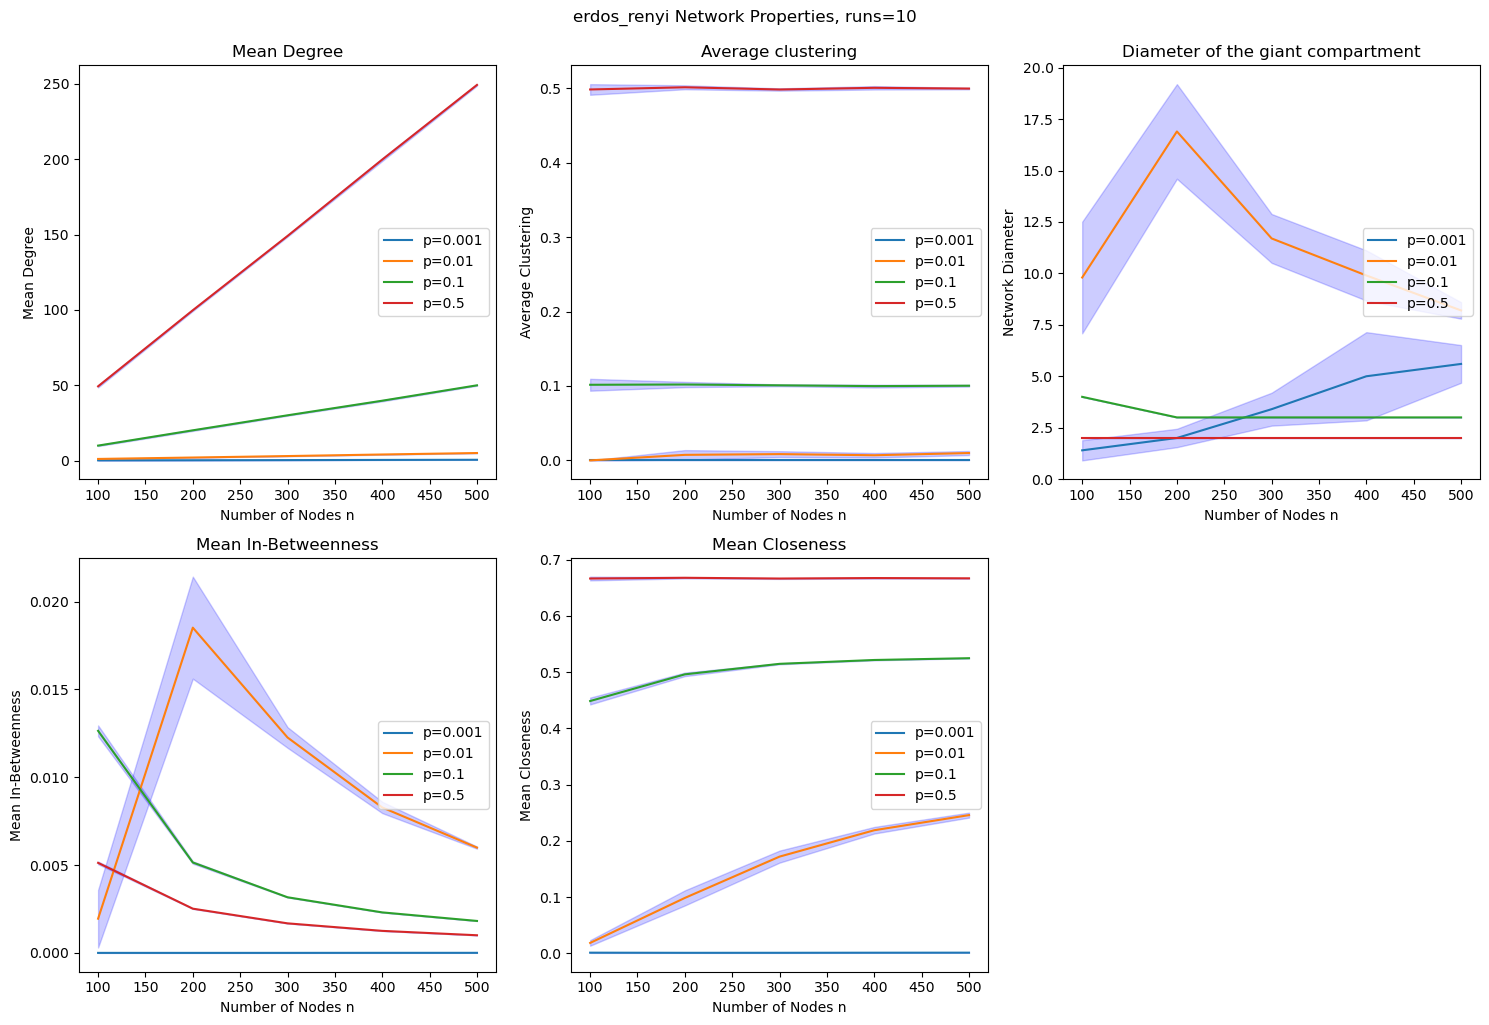

In [117]:
result_er = graph_exploration('erdos_renyi',ns_er,ps_er,10)
result_er.save_to_csv('erdos_renyi')
# for m in range(0,1):
#     print(f"M={m}")
#     new_results_er = graph_exploration('erdos_renyi',ns_er,ps_er,7)
#     old_results_er = graph_experiment('erdos_renyi',ns_er,ps_er,0)
#     old_results_er.read_from_csv('erdos_renyi')
#     new_results_er.combine_results(old_results_er)
#     new_results_er.save_to_csv('erdos_renyi')

plot_graph_exploration(result_er)

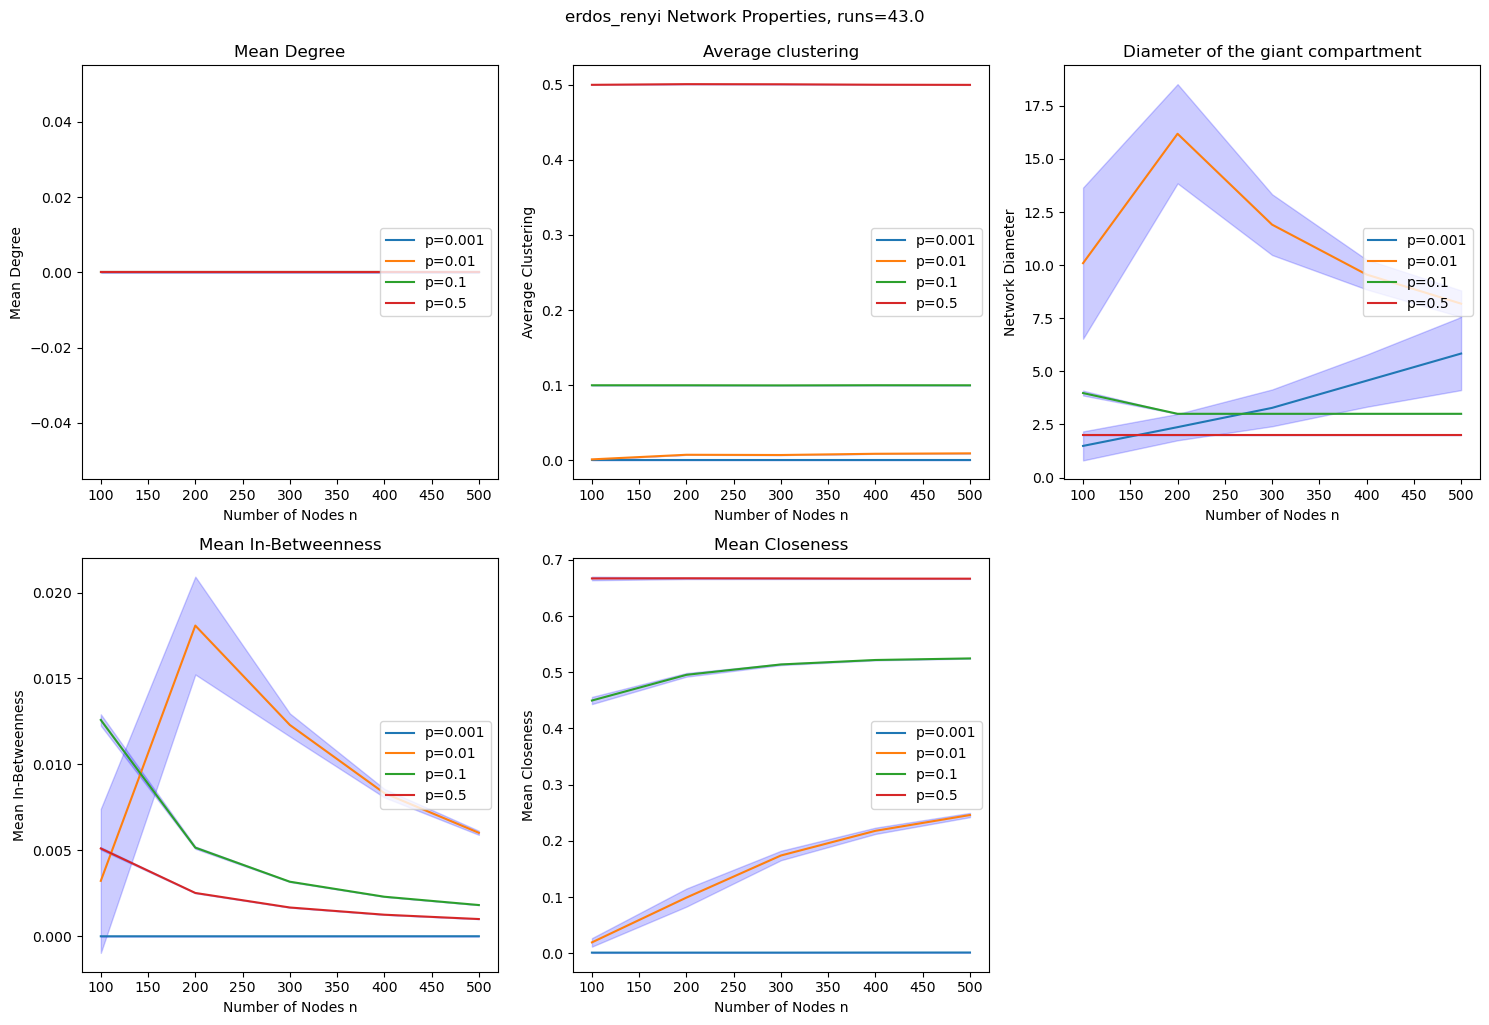

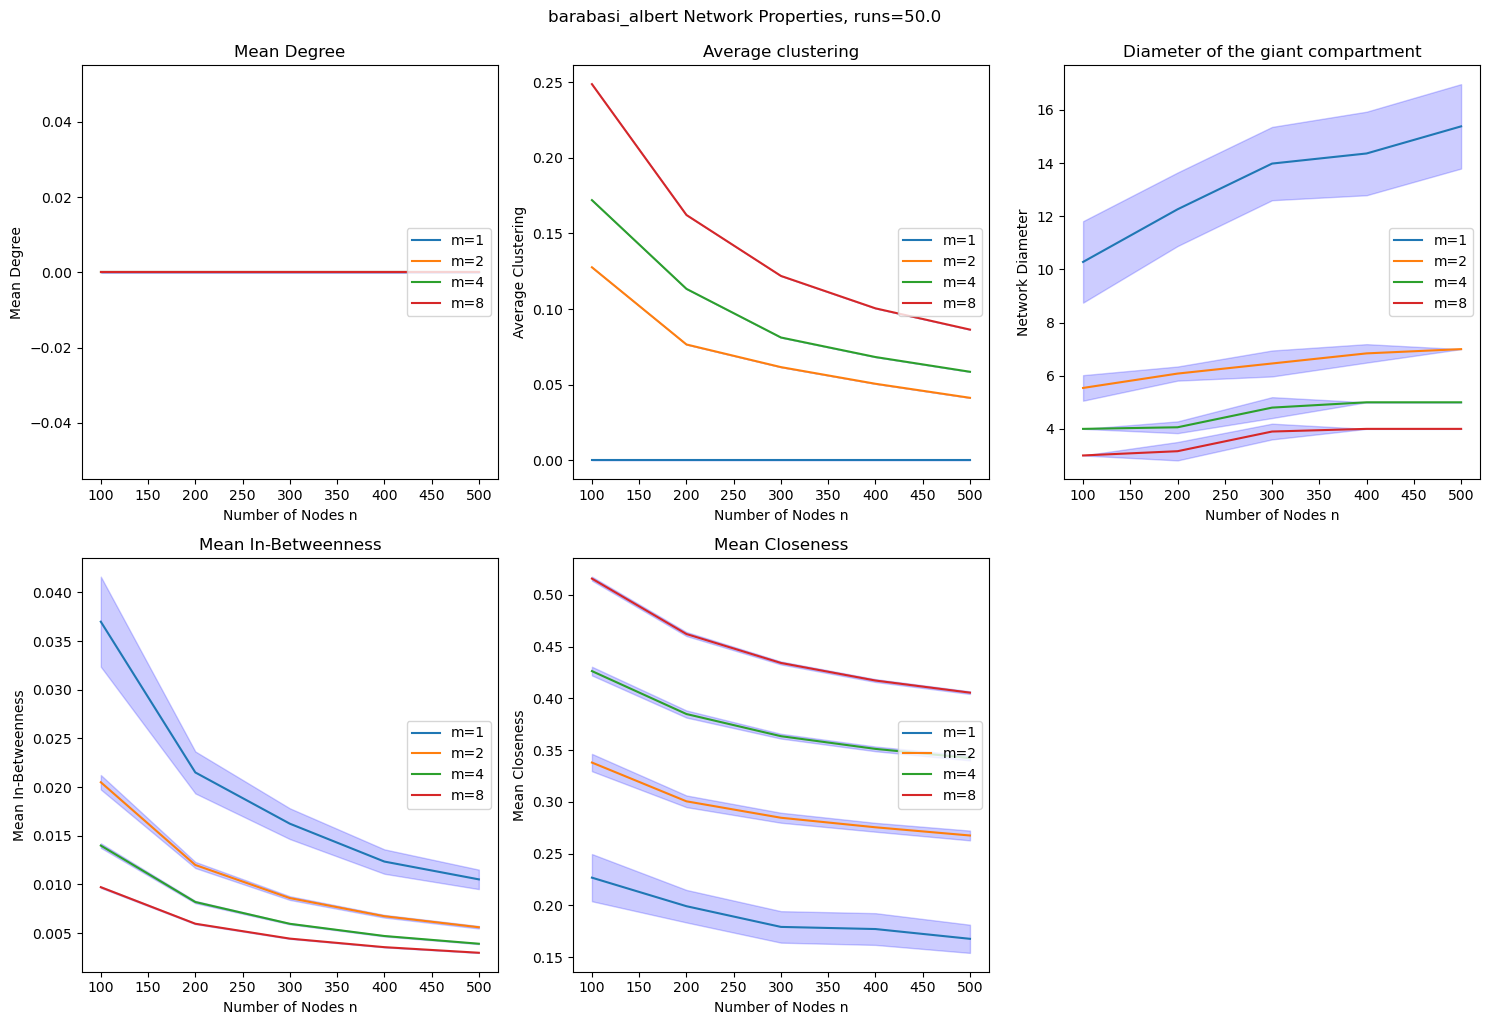

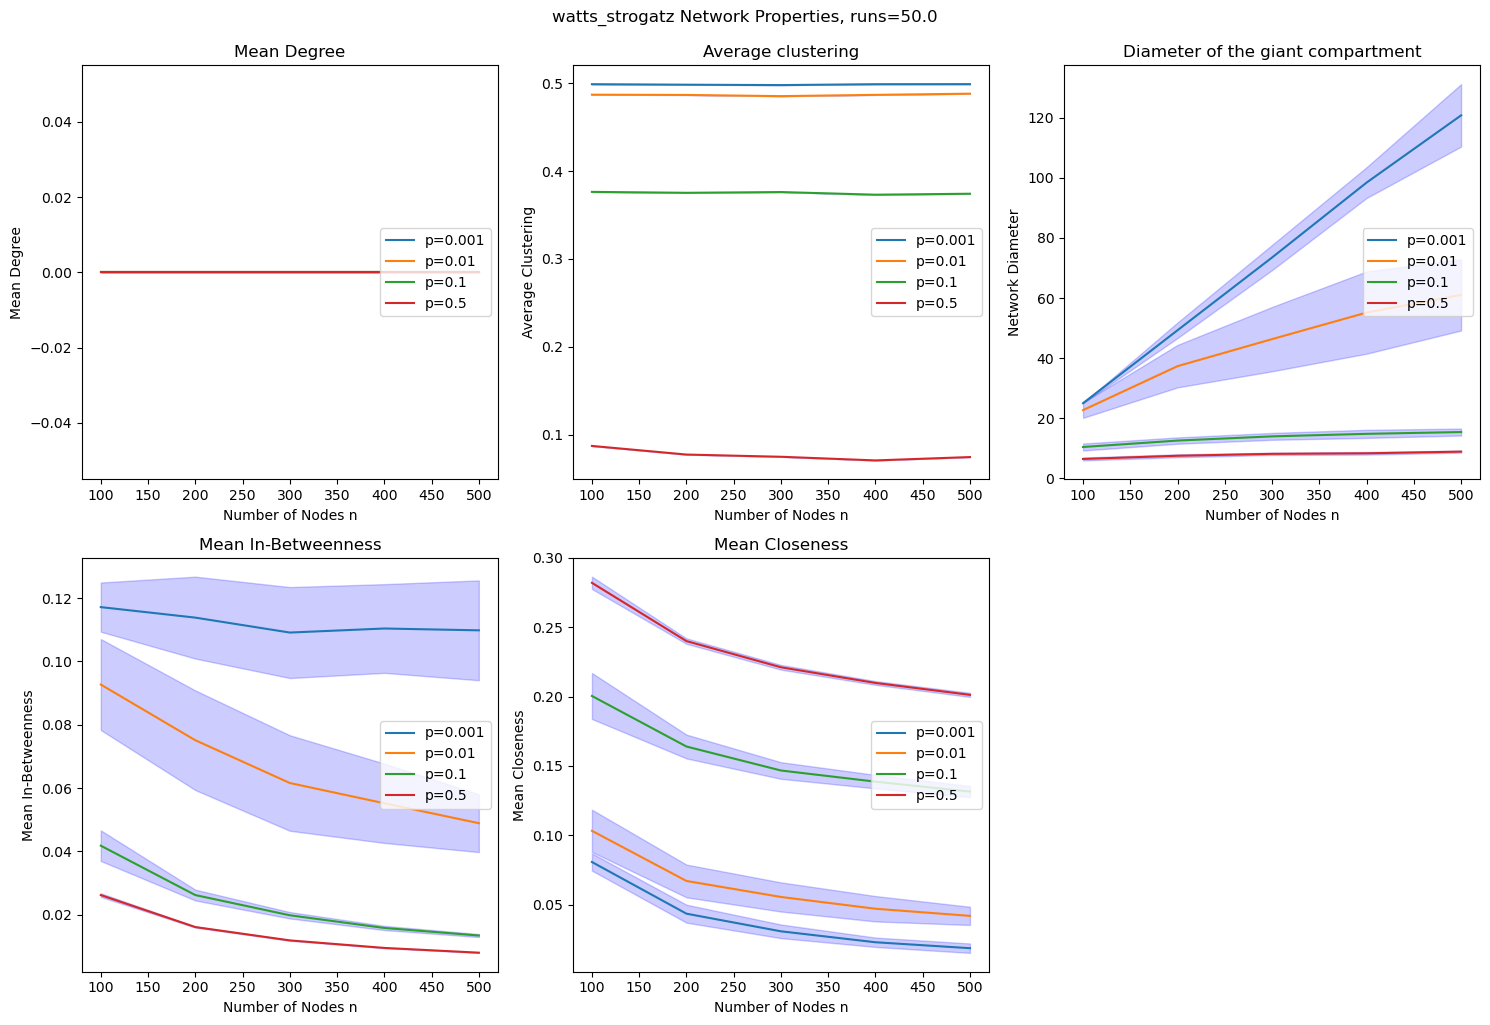

In [106]:
result_er = graph_experiment('erdos_renyi',ns_er,ps_er,0)
result_ba = graph_experiment('barabasi_albert',ns_ba,ms_ba,0)
result_ws = graph_experiment('watts_strogatz',ns_ws,ps_ws,0)

result_er.read_from_csv('erdos_renyi')
result_ba.read_from_csv('barabasi_albert')
result_ws.read_from_csv('watts_strogatz')

plot_graph_exploration(result_er)
plot_graph_exploration(result_ba)
plot_graph_exploration(result_ws)


computing for beta=0.01
computing for beta=0.02
computing for beta=0.03
computing for beta=0.04


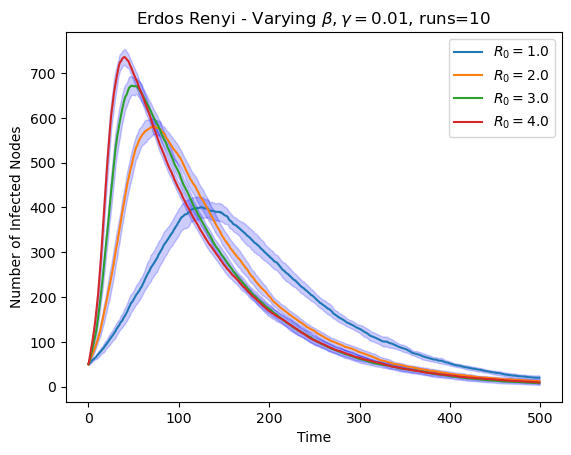

computing for beta=0.01
computing for beta=0.02
computing for beta=0.03
computing for beta=0.04


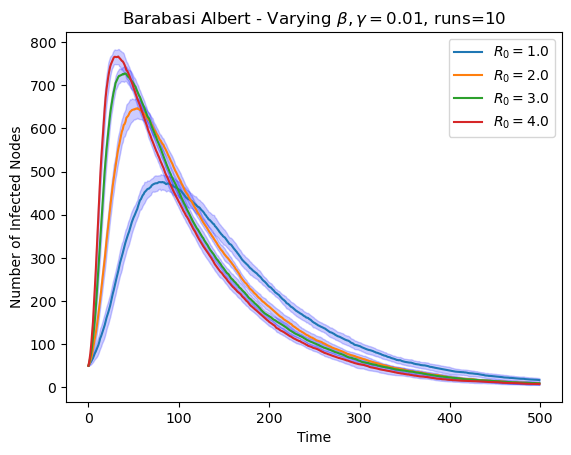

computing for beta=0.01
computing for beta=0.02
computing for beta=0.03
computing for beta=0.04


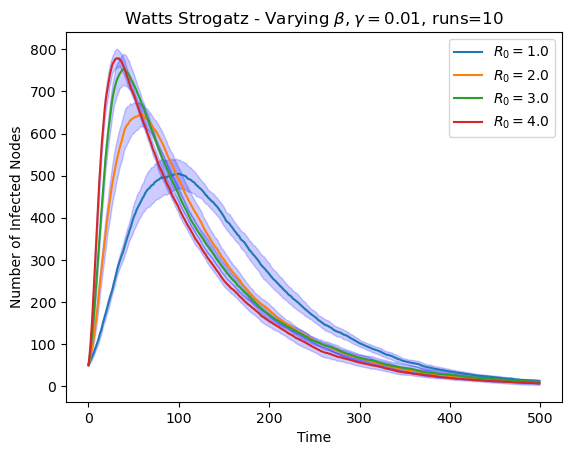

In [48]:
# Experiment with parameters (beta, gamma, fraction_infected) on given network type
%matplotlib inline
def experiment_parameters(graphtype, params, max_time, param_name, param_values, title_prefix,runs):
    for value in param_values:
        params[param_name] = value
        R0 = value/params['gamma']
        print(f"computing for beta={value}")
        trends_list = []
        for i in range(runs):
            if graphtype=='er':
                graph = nx.erdos_renyi_graph(1000, 0.005) # N nodes, p chance for edge creation
            elif graphtype =='ba':
                graph = nx.barabasi_albert_graph(1000,3) # N nodes, m edges from new node
            elif graphtype =='ws':
                graph = nx.watts_strogatz_graph(1000,10,0.01) # N nodes, k connected neighbours, p probability of rewiring each edge

            data = simulate_network_sir(graph,max_time,params,return_trends=True)
            trends = data[0]['trends']['node_count'][1]
            trends_list.append(trends)
        avg_trends = np.mean(np.array(trends_list),axis=0)
        std_trends = np.std(np.array(trends_list),axis=0)
        # Plotting the trends

        plt.plot(range(len(avg_trends)), avg_trends, label=rf"$R_0={round(R0,2)}$")
        plt.fill_between(range(len(avg_trends)), avg_trends-std_trends, avg_trends+std_trends, color='b', alpha=0.2)

    plt.xlabel("Time")
    plt.ylabel("Number of Infected Nodes")
    plt.title(rf"{title_prefix} - Varying $\beta,\gamma={params['gamma']}$, runs={runs}")
    plt.legend()
    plt.show()

# Example usage:
params['beta'] = 0.01  # Reset to default
params['gamma'] = 0.01  # Reset to default
params['fraction_infected'] = 0.05  # Reset to default  

experiment_parameters('er', params, 500, 'beta', [0.01, 0.02, 0.03, 0.04], "Erdos Renyi",10)

experiment_parameters('ba', params, 500, 'beta', [0.01, 0.02, 0.03, 0.04], "Barabasi Albert",10)

experiment_parameters('ws', params, 500, 'beta', [0.01, 0.02, 0.03, 0.04], "Watts Strogatz",10)
        

In [162]:
params['beta'] = 0.02  # Reset to default
params['gamma'] = 0.01  # Reset to default
params['fraction_infected'] = 0.05  # Reset to default  


def compare_graphtypes(graphtypes,runs,gs=None):
    if gs:
        for g,graphtype in gs:
            print(f"computing for graph type={graphtype}")
            trends_list=[]
            for i in range(runs):
                trends = simulate_network_sir(g,150,params,return_trends=True)[0]['trends']['node_count'][1]
                trends_list.append(trends)
            avg_trends = np.mean(np.array(trends_list),axis=0)
            std_trends = np.std(np.array(trends_list),axis=0)
            plt.plot(range(len(avg_trends)),avg_trends,label=graphtype)
            plt.fill_between(range(len(avg_trends)),avg_trends-std_trends,avg_trends+std_trends,color='b',alpha=0.1)
    if not gs:
        for graphtype in graphtypes:
            print(f"computing for graph type={graphtype}")
            trends_list=[]
            for i in range(runs):
                if graphtype=='er':
                    graph = nx.erdos_renyi_graph(250, 0.005) # N nodes, p chance for edge creation
                elif graphtype =='ba':
                    graph = nx.barabasi_albert_graph(1000,3) # N nodes, m edges from new node
                elif graphtype =='ws':
                    graph = nx.watts_strogatz_graph(1000,10,0.01) # N nodes, k connected neighbours, p probability of rewiring each edge
                
                trends = simulate_network_sir(graph,400,params,return_trends=True)[0]['trends']['node_count'][1]
                trends_list.append(trends)
            avg_trends = np.mean(np.array(trends_list),axis=0)
            std_trends = np.std(np.array(trends_list),axis=0)
            plt.plot(range(len(avg_trends)),avg_trends,label=graphtype)
            plt.fill_between(range(len(avg_trends)),avg_trends-std_trends,avg_trends+std_trends,color='b',alpha=0.2)
    plt.xlabel('Time')
    plt.ylabel('Infected Nodes')
    plt.title(rf'Comparison between graph types, $R_0={params['beta']/params['gamma']}$,runs={runs}')
    plt.legend()
    plt.show()



In [10]:
# Connection probability


# Load Socipatterns data

Loaded graph with 375 nodes and 1639 edges


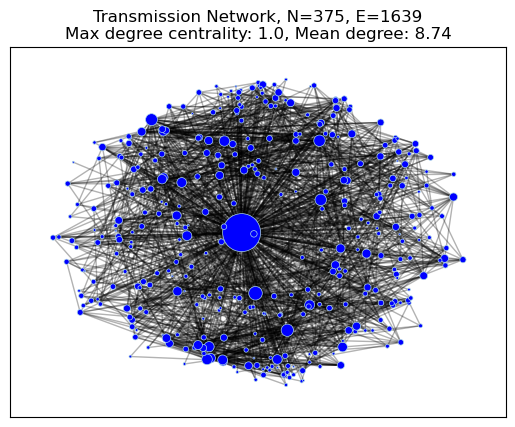

<Figure size 500x500 with 0 Axes>

(375,1639)
Average Degree:  8.741333333333333
Average Clustering Coefficient:  0.5555319463686345
Diameter:  2
Mean In-Betweenness:  0.0026183041581243753
Mean Closeness:  0.5066033489568377


In [155]:
%matplotlib inline
# g = nx.read_edgelist("data/transmission_network.csv", delimiter=";", create_using=nx.Graph(),data=False)
g_array = np.loadtxt("data/transmission_network.csv",delimiter=";")
g = nx.from_numpy_array(g_array)
print("Loaded graph with {} nodes and {} edges".format(g.number_of_nodes(), g.number_of_edges()))

# Show graph info
# pos = nx.kamada_kawai_layout(g)
# pos = nx.planar_layout(g)
pos = nx.spring_layout(g)

degrees = g.degree()
node_sizes = [degrees[n] * 2 for n in g.nodes()]  # Scale by 10 for visibility

nx.draw_networkx_nodes(g, pos, node_size=node_sizes, linewidths=0.5, edgecolors='lightblue', node_color="blue", alpha=1.0)
nx.draw_networkx_edges(g, pos, edge_color="black", alpha=0.3)
centrality = nx.degree_centrality(g)
degrees = [d for n, d in g.degree()]
mean_degree = sum(degrees) / len(degrees)

plt.title("Transmission Network, N={}, E={}".format(g.number_of_nodes(), g.number_of_edges()) 
          + "\n" 
          + f"Max degree centrality: {round(max(centrality.values()),3)}" 
          + f", Mean degree: {round(mean_degree,2)}")

plt.figure(figsize=(5,5))
plt.show()

def compute_graph_metrics(g):
    nodes = g.number_of_nodes()
    edges = g.number_of_edges()
    degrees = [d for n, d in g.degree()]
    avg_degree = sum(degrees) / len(degrees)
    avg_clustering = nx.average_clustering(g)
    diameter = nx.diameter(g)
    mean_inbetweenness = np.mean(list(nx.betweenness_centrality(g).values()))
    mean_closeness = np.mean(list(nx.closeness_centrality(g).values()))

    print(f"({nodes},{edges})")
    print("Average Degree: ", avg_degree)
    print("Average Clustering Coefficient: ", avg_clustering)
    print("Diameter: ", diameter)
    print("Mean In-Betweenness: ", mean_inbetweenness)
    print("Mean Closeness: ", mean_closeness)

compute_graph_metrics(g)

In [140]:
# try to approximate sociopatterns network with erdos renyi
N = g.number_of_nodes()
E = g.number_of_edges()
p = (2 * E) / (N * (N - 1))
print("Approximated Erdos Renyi p: ", p)
print()
er_g = nx.erdos_renyi_graph(N,p)
compute_graph_metrics(er_g)


Approximated Erdos Renyi p:  0.023372549019607843

(375,1615)
Average Degree:  8.613333333333333
Average Clustering Coefficient:  0.02338126755711895
Diameter:  5
Mean In-Betweenness:  0.005333218639637184
Mean Closeness:  0.3359796334154198


In [167]:
# try to approximate sociopatterns network with barabasi albert
N = g.number_of_nodes()
degrees = [d for n, d in g.degree()]
avg_degree = sum(degrees) / len(degrees)
m = int(avg_degree/2 )
print("Approximated Barabasi Albert m: ", m)
print()
ba_g = nx.barabasi_albert_graph(N, m)
compute_graph_metrics(ba_g)


Approximated Barabasi Albert m:  4

(375,1484)
Average Degree:  7.914666666666666
Average Clustering Coefficient:  0.07230501076599166
Diameter:  5
Mean In-Betweenness:  0.004906711014895843
Mean Closeness:  0.35607448491658555


In [187]:
# try to approximate sociopatterns network with watts strogatz
N = g.number_of_nodes()
degrees = [d for n, d in g.degree()]
avg_degree = sum(degrees) / len(degrees)
k =8
p = .4
print("Approximated Watts Strogatz k,p: ", k, p)
print()
ws_g = nx.watts_strogatz_graph(N, k, p)
compute_graph_metrics(ws_g)

Approximated Watts Strogatz k,p:  8 0.4

(375,1500)
Average Degree:  8.0
Average Clustering Coefficient:  0.1464923520923521
Diameter:  5
Mean In-Betweenness:  0.006033997123099788
Mean Closeness:  0.30818897911373305


computing for graph type=sociopatterns
computing for graph type=erdos_renyi
computing for graph type=barabasi_albert
computing for graph type=watts_strogatz


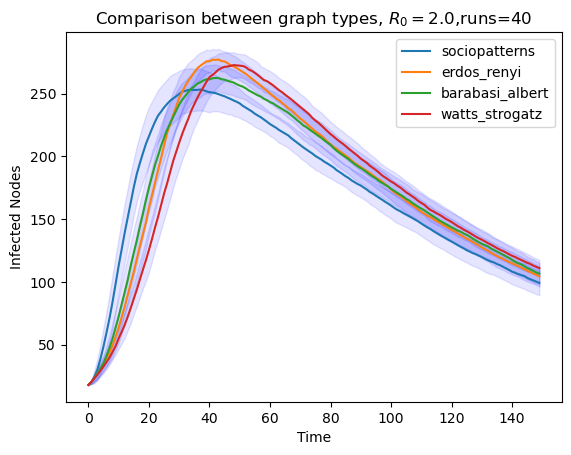

In [189]:
compare_graphtypes([],40,gs=[(g,'sociopatterns'),(er_g,'erdos_renyi'),(ba_g,'barabasi_albert'),(ws_g,'watts_strogatz')])

In [ ]:
def vaccination_experiment(strat,vac_amounts,max_time,runs,test_accuracy=1,plot=False):
    colors = ['red','blue','green','orange','black']

    mean_trends = []
    std_trends = []
    peaks = []

    for i,value in enumerate(vac_amounts):
        print(f"computing or vac amount: {value}")
        vac = Vaccination_strategy(strat,value)
        trends = []

        for run in range(runs):
            trend = simulate_network_sir(g,max_time,params,seed=0,vaccination=vac,plot=False,return_trends=True,test_accuracy=test_accuracy)[0]['trends']['node_count'][1]
            trends.append(trend)
        mean_trends.append(np.mean(trends,axis=0))
        std_trends.append(np.std(trends,axis=0))
        
        peaks.append(max(mean_trends[-1]))
        
        if plot:
            label = f"I, v={value}"
            plt.plot(range(max_time),mean_trends[-1],label=label,color=colors[i],linewidth=1)
            plt.errorbar(range(max_time),mean_trends[-1],std_trends[-1],color=colors[i],linewidth=0.5,capsize=2)
            # plt.fill_between(range(max_time), mean_trends[-1]-std_trends[-1], mean_trends[-1]+std_trends[-1], color=colors[i], alpha=0.1)

            
            plt.plot([0,max_time],[peaks[-1],peaks[-1]],color=colors[i],linewidth=0.5,linestyle='--')

    max_difference = np.array(peaks[0]) - np.array(peaks[-1])
    differences = np.array(peaks[0])-np.array(peaks)

    if plot:
        plt.xlabel('days')
        plt.ylabel('infections')
        plt.title(f'{strat} Vaccination Strategy')

        plt.xlim(0,20)
        plt.ylim(0,300)

        plt.legend()
        plt.show()

    print(f"average over {runs} runs, R0=2, beta=0.2, gamma=0.1")
    print(f"max impact = {round(max_difference,2)} = {round(max_difference*100/peaks[0],2)}%")

    return differences



computing or vac anount: 0
computing or vac anount: 1
computing or vac anount: 3
computing or vac anount: 5
computing or vac anount: 10


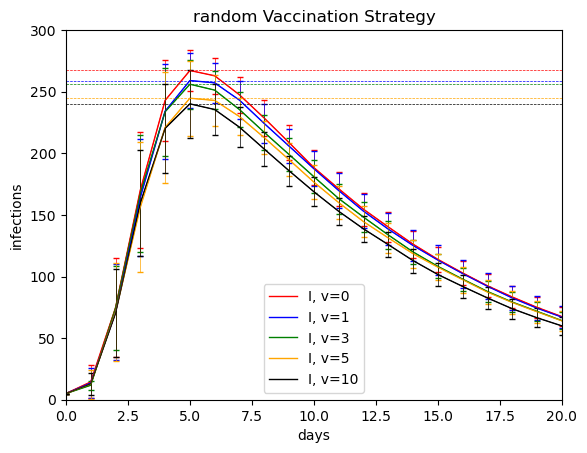

average over 100 runs, R0=2, beta=0.2, gamma=0.1
max impact = 27.07 = 10.13%
computing or vac anount: 0
computing or vac anount: 1
computing or vac anount: 3
computing or vac anount: 5
computing or vac anount: 10


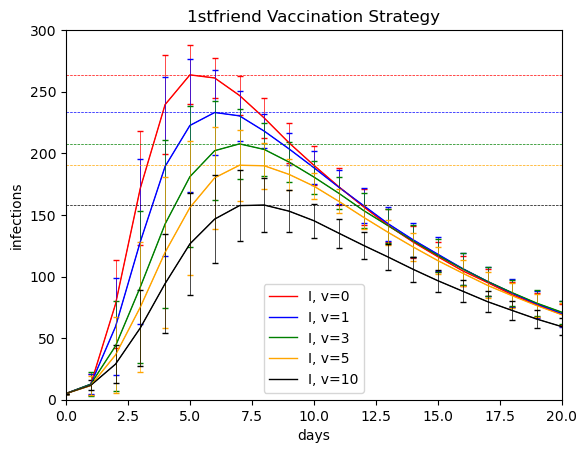

average over 100 runs, R0=2, beta=0.2, gamma=0.1
max impact = 105.68 = 40.08%
computing or vac anount: 0
computing or vac anount: 1
computing or vac anount: 3
computing or vac anount: 5
computing or vac anount: 10


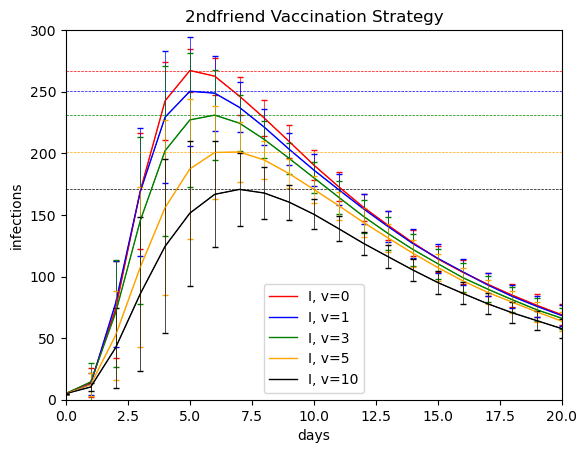

average over 100 runs, R0=2, beta=0.2, gamma=0.1
max impact = 96.49 = 36.11%
computing or vac anount: 0
computing or vac anount: 1
computing or vac anount: 3
computing or vac anount: 5
computing or vac anount: 10


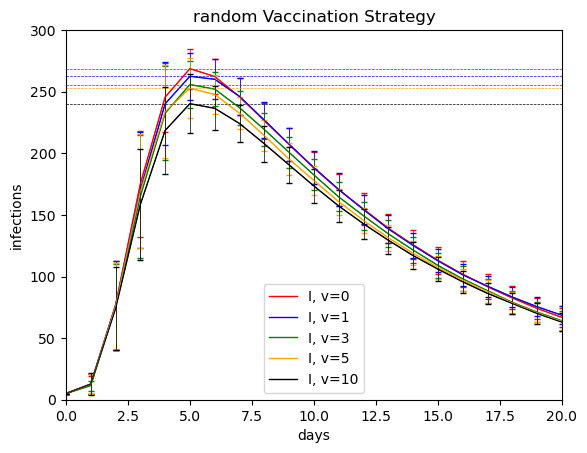

average over 100 runs, R0=2, beta=0.2, gamma=0.1
max impact = 28.42 = 10.58%
computing or vac anount: 0
computing or vac anount: 1
computing or vac anount: 3
computing or vac anount: 5
computing or vac anount: 10


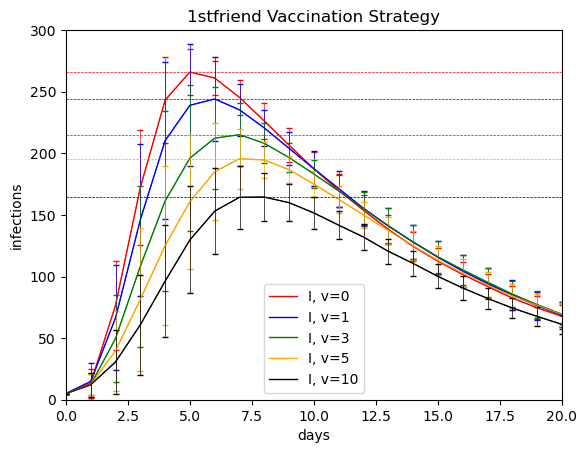

average over 100 runs, R0=2, beta=0.2, gamma=0.1
max impact = 101.53 = 38.16%
computing or vac anount: 0
computing or vac anount: 1
computing or vac anount: 3
computing or vac anount: 5
computing or vac anount: 10


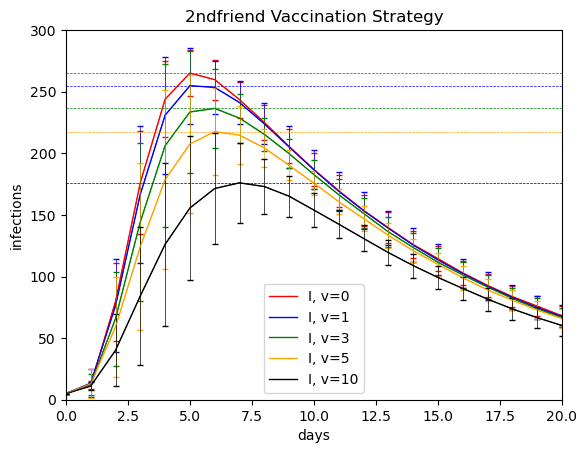

average over 100 runs, R0=2, beta=0.2, gamma=0.1
max impact = 89.11 = 33.61%
computing or vac anount: 0
computing or vac anount: 1
computing or vac anount: 3
computing or vac anount: 5
computing or vac anount: 10


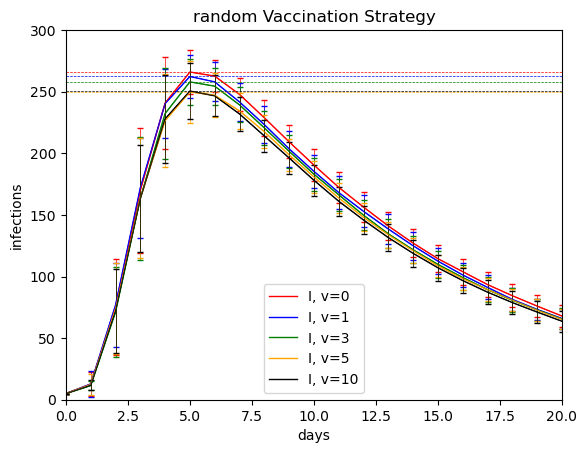

average over 100 runs, R0=2, beta=0.2, gamma=0.1
max impact = 15.46 = 5.81%
computing or vac anount: 0
computing or vac anount: 1
computing or vac anount: 3
computing or vac anount: 5
computing or vac anount: 10


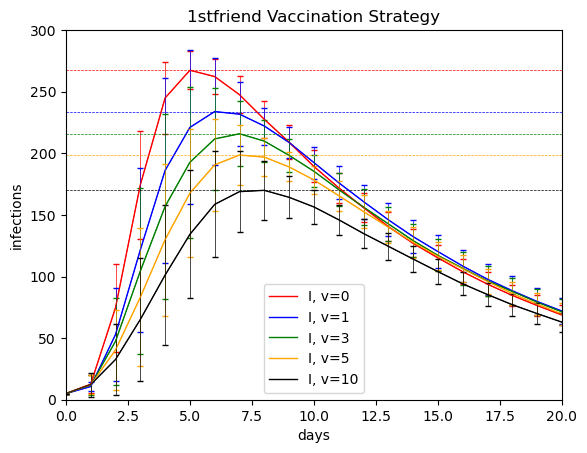

average over 100 runs, R0=2, beta=0.2, gamma=0.1
max impact = 97.47 = 36.45%
computing or vac anount: 0
computing or vac anount: 1
computing or vac anount: 3
computing or vac anount: 5
computing or vac anount: 10


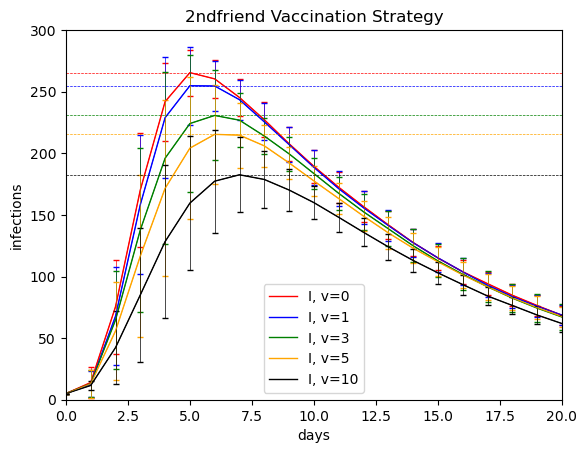

average over 100 runs, R0=2, beta=0.2, gamma=0.1
max impact = 82.91 = 31.23%


In [192]:
differences_list = {}

# Simulate SIR on this network with vaccinations
import matplotlib.pyplot as plt
params['beta'] = 0.2
params['gamma'] = 0.1
params['fraction_infected'] = 5/375
vac_amounts = [0,1,3,5,10]
accuracies = [1,0.75,0.5]
max_time = 21
runs = 100

differences_list['Random'] = {}
differences_list['First Friend'] = {}
differences_list['Second Friend'] = {}


for accuracy in accuracies:
    differences_list['Random'][accuracy] = vaccination_experiment('random',vac_amounts,max_time,runs,accuracy, plot=True)
    differences_list['First Friend'][accuracy] = vaccination_experiment('1stfriend',vac_amounts,max_time,runs,accuracy, plot=True)
    differences_list['Second Friend'][accuracy] = vaccination_experiment('2ndfriend',vac_amounts,max_time,runs,accuracy, plot=True)

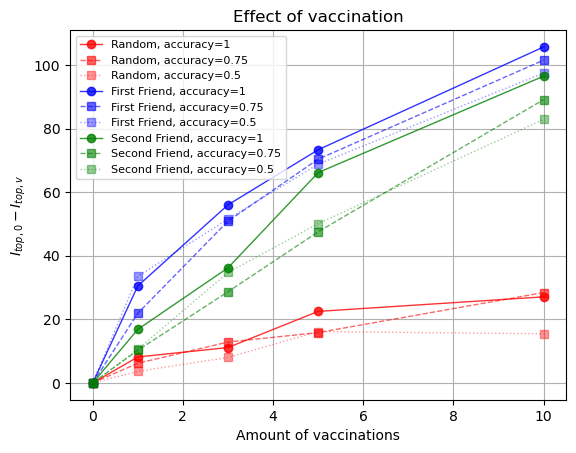

In [ ]:
colours = ['red','blue','green']
color_id = 0
for strat,dict in differences_list.items():
    i = 1
    for accuracy,difference in dict.items():
        if accuracy == 1:
            plt.plot(vac_amounts,difference, label=f"{strat}, accuracy={accuracy}",color=colours[color_id],linewidth=1,marker='o',alpha=1-0.2*i)
        elif accuracy == 0.75:
            plt.plot(vac_amounts,difference, label=f"{strat}, accuracy={accuracy}",color=colours[color_id],linewidth=1,marker='s',alpha=1-0.2*i,linestyle='--')
        elif accuracy == 0.5:
            plt.plot(vac_amounts,difference, label=f"{strat}, accuracy={accuracy}",color=colours[color_id],linewidth=1,marker='s',alpha=1-0.2*i,linestyle=':')
`x`
        i += 1
    color_id += 1
plt.ylabel(r"$I_{top,0} - I_{top,v}$")
plt.xlabel("Amount of vaccinations")
plt.title("Effect of vaccination")
plt.legend(fontsize=8)
plt.grid()
plt.show()

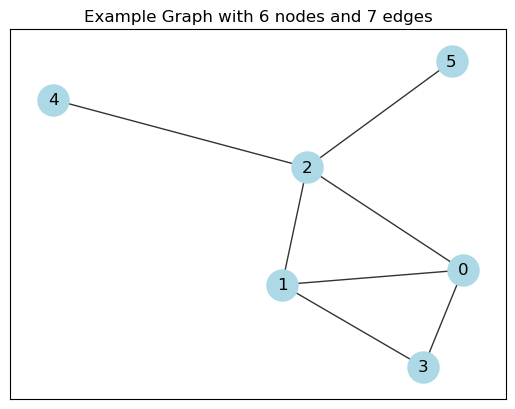

In [126]:
# make example graph with n=6, m=7 nodes and edges
example_graph = nx.Graph()
example_graph.add_edges_from([(0,1),(0,2),(0,3),(1,2),(1,3),(2,4),(2,5)])
#draw example graph
pos = nx.spring_layout(example_graph)
nx.draw_networkx_nodes(example_graph, pos, node_size=500, node_color="lightblue", alpha=1.0)
nx.draw_networkx_edges(example_graph, pos, edge_color="black", alpha=0.8)
nx.draw_networkx_labels(example_graph, pos, font_size=12, font_color="black")
plt.title("Example Graph with 6 nodes and 7 edges")
plt.show()